# Pyspark basics

This notebook demonstrates the basics operations of working with Pyspark Dataframe.

## 1. Spark Session

**SparkSession**: an entry point to PySpark to underlie PySpark functionality to programmatically create PySpark RDD, DataFrame and Dataset (since v.2.0 that replaces SQLContext, HiveCOntext, and others defined before this version).

In [1]:
import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local[*]") \
        .appName("PySpark Basics") \
        .getOrCreate()

In [2]:
spark

## 2. Reading Data

Accpeted formats: CSV, JSON, Parquet, etc.

Use `spark.read` to read different file formats.

In [9]:
csv_file = '../01-selenium/data/myheroacademia.csv'
df = spark.read.csv(
    csv_file,
    header=True
)

Similarly, read json by `spark.read.json`, read parquet by `spark.read.parquet`.

**Print out the schema** by the `printSchema()` method.

In [10]:
df.printSchema()

root
 |-- Episode: string (nullable = true)
 |-- Character: string (nullable = true)
 |-- Type of appearance: string (nullable = true)



**Define our own schema**

In [11]:
from pyspark.sql.types import *

data_schema = [
    StructField('Episode', IntegerType(), False),
    StructField('Character', StringType(), False),
    StructField('Type of appearance', StringType(), False)
]
final_struct = StructType(fields=data_schema)

df = spark.read.csv(
    csv_file,
    header=True,
    schema=final_struct
)

In [12]:
df.printSchema()

root
 |-- Episode: integer (nullable = true)
 |-- Character: string (nullable = true)
 |-- Type of appearance: string (nullable = true)



Q: Why is the schema accepts nullable while the `data_schema` declared all nullable as False.

## 3. Inspecting Data

In [13]:
df.schema

StructType([StructField('Episode', IntegerType(), True), StructField('Character', StringType(), True), StructField('Type of appearance', StringType(), True)])

In [14]:
df.dtypes

[('Episode', 'int'), ('Character', 'string'), ('Type of appearance', 'string')]

In [15]:
df.head(3)

[Row(Episode=1, Character='Izuku Midoriya', Type of appearance='Direct'),
 Row(Episode=1, Character='Tsubasa', Type of appearance='Flashback'),
 Row(Episode=1, Character='Katsuki Bakugo', Type of appearance='Direct')]

In [16]:
df.show()

+-------+----------------+------------------+
|Episode|       Character|Type of appearance|
+-------+----------------+------------------+
|      1|  Izuku Midoriya|            Direct|
|      1|         Tsubasa|         Flashback|
|      1|  Katsuki Bakugo|            Direct|
|      1|   Giant Villain|            Direct|
|      1|Luminescent Baby|         Flashback|
|      1|       All Might|            Direct|
|      1|      Death Arms|            Direct|
|      1|       Backdraft|            Direct|
|      1|     Kamui Woods|            Direct|
|      1|        Mt. Lady|            Direct|
|      1|  Sludge Villain|            Direct|
|      1|   Inko Midoriya|         Flashback|
|      1|Hisashi Midoriya|         Mentioned|
|      2|  Izuku Midoriya|            Direct|
|      2|       All Might|            Direct|
|      2|  Sludge Villain|            Direct|
|      2|  Katsuki Bakugo|            Direct|
|      2|     All For One|         Mentioned|
|      2|  Toxic Chainsaw|        

In [18]:
df.first()

Row(Episode=1, Character='Izuku Midoriya', Type of appearance='Direct')

In [20]:
df.take(3) # Similar to df.head(3)

[Row(Episode=1, Character='Izuku Midoriya', Type of appearance='Direct'),
 Row(Episode=1, Character='Tsubasa', Type of appearance='Flashback'),
 Row(Episode=1, Character='Katsuki Bakugo', Type of appearance='Direct')]

In [21]:
df.describe().show()

+-------+------------------+---------+------------------+
|summary|           Episode|Character|Type of appearance|
+-------+------------------+---------+------------------+
|  count|              4184|     4185|              4183|
|   mean| 60.08269598470363|     null|              null|
| stddev|31.988976507896925|     null|              null|
|    min|                 1|   Airjet|             Cameo|
|    max|               113|Yuyu Haya|        voice only|
+-------+------------------+---------+------------------+



In [22]:
df.columns

['Episode', 'Character', 'Type of appearance']

In [23]:
df.count()

4196

In [27]:
df.distinct().count() # df.distinct() returns a DataFrame with distinct rows

4186

## 4. Columns Manipulation

### 4.1. Adding columns

In [28]:
df = df.withColumn('Episode index', df.Episode - 1)

In [29]:
df.show(5)

+-------+----------------+------------------+-------------+
|Episode|       Character|Type of appearance|Episode index|
+-------+----------------+------------------+-------------+
|      1|  Izuku Midoriya|            Direct|            0|
|      1|         Tsubasa|         Flashback|            0|
|      1|  Katsuki Bakugo|            Direct|            0|
|      1|   Giant Villain|            Direct|            0|
|      1|Luminescent Baby|         Flashback|            0|
+-------+----------------+------------------+-------------+
only showing top 5 rows



### 4.2. Update columns

In [30]:
df = df.withColumnRenamed('Episode index', 'Episode Index')
df.show(5)

+-------+----------------+------------------+-------------+
|Episode|       Character|Type of appearance|Episode Index|
+-------+----------------+------------------+-------------+
|      1|  Izuku Midoriya|            Direct|            0|
|      1|         Tsubasa|         Flashback|            0|
|      1|  Katsuki Bakugo|            Direct|            0|
|      1|   Giant Villain|            Direct|            0|
|      1|Luminescent Baby|         Flashback|            0|
+-------+----------------+------------------+-------------+
only showing top 5 rows



### 4.3. Delete Columns

In [31]:
df = df.drop('Episode Index')
df.show(5)

+-------+----------------+------------------+
|Episode|       Character|Type of appearance|
+-------+----------------+------------------+
|      1|  Izuku Midoriya|            Direct|
|      1|         Tsubasa|         Flashback|
|      1|  Katsuki Bakugo|            Direct|
|      1|   Giant Villain|            Direct|
|      1|Luminescent Baby|         Flashback|
+-------+----------------+------------------+
only showing top 5 rows



## 5. Handling Missing Values

### 5.1. Remove rows having missing values

In [37]:
# Augmented data
data = [
    (0, 704, 'STANDARD', None, 'PR', 30100),
    (1, 704, None, 'PASEO COSTA DEL SUR', 'PR', None),
    (2, 709, None, 'BDA SAN LUIS', 'PR', 3700),
    (3, 76166, 'UNIQUE', 'CINGULAR WIRELESS', 'TX', 84000),
    (4, 76177, 'STANDARD', None, 'TX', None)
]
columns = ['id', 'zipcode', 'type', 'city', 'state', 'population']

data = spark.createDataFrame(data=data, schema=columns)
data.printSchema()

root
 |-- id: long (nullable = true)
 |-- zipcode: long (nullable = true)
 |-- type: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- population: long (nullable = true)



In [41]:
data.na.drop().show()

+---+-------+------+-----------------+-----+----------+
| id|zipcode|  type|             city|state|population|
+---+-------+------+-----------------+-----+----------+
|  3|  76166|UNIQUE|CINGULAR WIRELESS|   TX|     84000|
+---+-------+------+-----------------+-----+----------+



In [42]:
data.na.drop(subset='population').show()

+---+-------+--------+-----------------+-----+----------+
| id|zipcode|    type|             city|state|population|
+---+-------+--------+-----------------+-----+----------+
|  0|    704|STANDARD|             null|   PR|     30100|
|  2|    709|    null|     BDA SAN LUIS|   PR|      3700|
|  3|  76166|  UNIQUE|CINGULAR WIRELESS|   TX|     84000|
+---+-------+--------+-----------------+-----+----------+



### 5.2. Replacing Missing Values with A New Value

In [51]:
from pyspark.sql.functions import mean, stddev, col

mean_value = data.select(mean(data.population)).collect()[0][0]
mean_value

39266.666666666664

In [52]:
data.na.fill(mean_value).show()

+---+-------+--------+-------------------+-----+----------+
| id|zipcode|    type|               city|state|population|
+---+-------+--------+-------------------+-----+----------+
|  0|    704|STANDARD|               null|   PR|     30100|
|  1|    704|    null|PASEO COSTA DEL SUR|   PR|     39266|
|  2|    709|    null|       BDA SAN LUIS|   PR|      3700|
|  3|  76166|  UNIQUE|  CINGULAR WIRELESS|   TX|     84000|
|  4|  76177|STANDARD|               null|   TX|     39266|
+---+-------+--------+-------------------+-----+----------+



In [55]:
data.na.fill('COSTA RICA').show()

+---+-------+----------+-------------------+-----+----------+
| id|zipcode|      type|               city|state|population|
+---+-------+----------+-------------------+-----+----------+
|  0|    704|  STANDARD|         COSTA RICA|   PR|     30100|
|  1|    704|COSTA RICA|PASEO COSTA DEL SUR|   PR|      null|
|  2|    709|COSTA RICA|       BDA SAN LUIS|   PR|      3700|
|  3|  76166|    UNIQUE|  CINGULAR WIRELESS|   TX|     84000|
|  4|  76177|  STANDARD|         COSTA RICA|   TX|      null|
+---+-------+----------+-------------------+-----+----------+



Numerical value will only be added to numeric columns, similar to other data type.

In [58]:
data.na.fill("STANDARD", subset=["type"]) \
    .na.fill("COSTA RICA", subset=["city"]) \
    .show()

+---+-------+--------+-------------------+-----+----------+
| id|zipcode|    type|               city|state|population|
+---+-------+--------+-------------------+-----+----------+
|  0|    704|STANDARD|         COSTA RICA|   PR|     30100|
|  1|    704|STANDARD|PASEO COSTA DEL SUR|   PR|      null|
|  2|    709|STANDARD|       BDA SAN LUIS|   PR|      3700|
|  3|  76166|  UNIQUE|  CINGULAR WIRELESS|   TX|     84000|
|  4|  76177|STANDARD|         COSTA RICA|   TX|      null|
+---+-------+--------+-------------------+-----+----------+



### 5.3. Replacing Missing indicator with New values

In [54]:
data.na.replace('BDA SAN LUIS', 'COSTA RICA').show()

+---+-------+--------+-------------------+-----+----------+
| id|zipcode|    type|               city|state|population|
+---+-------+--------+-------------------+-----+----------+
|  0|    704|STANDARD|               null|   PR|     30100|
|  1|    704|    null|PASEO COSTA DEL SUR|   PR|      null|
|  2|    709|    null|         COSTA RICA|   PR|      3700|
|  3|  76166|  UNIQUE|  CINGULAR WIRELESS|   TX|     84000|
|  4|  76177|STANDARD|               null|   TX|      null|
+---+-------+--------+-------------------+-----+----------+



## 6. Querying Data

### 6.1. SELECT

In [59]:
df.select('Character').show(5)

+----------------+
|       Character|
+----------------+
|  Izuku Midoriya|
|         Tsubasa|
|  Katsuki Bakugo|
|   Giant Villain|
|Luminescent Baby|
+----------------+
only showing top 5 rows



In [60]:
df.select('Character').count()

4196

In [61]:
df.select('Character').distinct().count()

277

In [62]:
df.select(['Episode', 'Character']).show(5)

+-------+----------------+
|Episode|       Character|
+-------+----------------+
|      1|  Izuku Midoriya|
|      1|         Tsubasa|
|      1|  Katsuki Bakugo|
|      1|   Giant Villain|
|      1|Luminescent Baby|
+-------+----------------+
only showing top 5 rows



### 6.2. Filter

In [63]:
from pyspark.sql.functions import col, lit

df.filter((col('Episode') >= 5) & (col('Character') <= 'H')).show(5)

+-------+-----------------+------------------+
|Episode|        Character|Type of appearance|
+-------+-----------------+------------------+
|      5|        All Might|            Direct|
|      5| Eijiro Kirishima|            Direct|
|      5|   Denki Kaminari|            Direct|
|      5|Fumikage Tokoyami|            Direct|
|      6|   Denki Kaminari|            Direct|
+-------+-----------------+------------------+
only showing top 5 rows



In [66]:
df.filter((df.Episode >= 5) & (df.Character <= 'H')).show(5)

+-------+-----------------+------------------+
|Episode|        Character|Type of appearance|
+-------+-----------------+------------------+
|      5|        All Might|            Direct|
|      5| Eijiro Kirishima|            Direct|
|      5|   Denki Kaminari|            Direct|
|      5|Fumikage Tokoyami|            Direct|
|      6|   Denki Kaminari|            Direct|
+-------+-----------------+------------------+
only showing top 5 rows



### 6.3. Between

In [68]:
df.filter(col('Episode').between(3, 4)).show(5)

+-------+--------------+------------------+
|Episode|     Character|Type of appearance|
+-------+--------------+------------------+
|      3|     All Might|            Direct|
|      3|Izuku Midoriya|            Direct|
|      3|    Death Arms|         Flashback|
|      3|       Slugger|         Flashback|
|      3|Katsuki Bakugo|            Direct|
+-------+--------------+------------------+
only showing top 5 rows



In [67]:
df.filter(df.Episode.between(3, 4)).show(5)

+-------+--------------+------------------+
|Episode|     Character|Type of appearance|
+-------+--------------+------------------+
|      3|     All Might|            Direct|
|      3|Izuku Midoriya|            Direct|
|      3|    Death Arms|         Flashback|
|      3|       Slugger|         Flashback|
|      3|Katsuki Bakugo|            Direct|
+-------+--------------+------------------+
only showing top 5 rows



### 6.4. When

In [70]:
from pyspark.sql.functions import when

df.select('Episode', 'Character', when(col('Type of appearance') == 'Direct', 1).otherwise(0).alias('Direct appeared')).show(5)

+-------+----------------+---------------+
|Episode|       Character|Direct appeared|
+-------+----------------+---------------+
|      1|  Izuku Midoriya|              1|
|      1|         Tsubasa|              0|
|      1|  Katsuki Bakugo|              1|
|      1|   Giant Villain|              1|
|      1|Luminescent Baby|              0|
+-------+----------------+---------------+
only showing top 5 rows



### 6.5. Like

In [73]:
df.filter(df.Character.rlike('^[MN]')).show(5)

+-------+-----------+------------------+
|Episode|  Character|Type of appearance|
+-------+-----------+------------------+
|      1|   Mt. Lady|            Direct|
|      2|   Mt. Lady|            Direct|
|      4| Mezo Shoji|            Direct|
|      4|       Nezu|            Direct|
|      5|Mina Ashido|            Direct|
+-------+-----------+------------------+
only showing top 5 rows



In [74]:
df.select('Character', df.Character.rlike('^[MN]')).show(5)

+----------------+-----------------------+
|       Character|RLIKE(Character, ^[MN])|
+----------------+-----------------------+
|  Izuku Midoriya|                  false|
|         Tsubasa|                  false|
|  Katsuki Bakugo|                  false|
|   Giant Villain|                  false|
|Luminescent Baby|                  false|
+----------------+-----------------------+
only showing top 5 rows



### 6.6. GroupBy

In [77]:
df.groupby('Character').count().show()

+--------------------+-----+
|           Character|count|
+--------------------+-----+
|Nomu (U.S.J.) (Sc...|    1|
|           Gang Orca|   16|
|    Danjuro’s father|    1|
|            Midnight|   38|
|Old Boss of the S...|    1|
|    Tomura Shigaraki|   55|
|       Yuga’s Mother|    1|
|        Kesagiri Man|    3|
|      Sansa Tamakawa|    3|
|       Cathleen Bate|    1|
|       Hekiji Tengai|    5|
|       Toru Hagakure|   64|
|           Mr. Brave|    6|
|                Deku|    8|
|              Snatch|    3|
|       Thousand Eyes|    2|
|        Daruma Ujiko|    6|
|           Hound Dog|   12|
|          Kota Izumi|    9|
|    Seiji Shishikura|    8|
+--------------------+-----+
only showing top 20 rows



### 6.7. Aggregation

In [80]:
from pyspark.sql.functions import min, max, count

df.filter(df.Episode.between(2, 4)) \
    .groupBy('Character') \
    .agg(
        min('Episode').alias('First appearance'),
        max('Episode').alias('Last appearance'),
        count('Episode').alias('Number of appearance')
    ).show(5)

+----------------+----------------+---------------+--------------------+
|       Character|First appearance|Last appearance|Number of appearance|
+----------------+----------------+---------------+--------------------+
|      Death Arms|               2|              4|                   3|
|     Yuga Aoyama|               4|              4|                   1|
|Eijiro Kirishima|               4|              4|                   1|
|   Recovery Girl|               4|              4|                   1|
|   Inko Midoriya|               2|              4|                   3|
+----------------+----------------+---------------+--------------------+
only showing top 5 rows



## 7. Data Visualization

Must be converted to Pandas Dataframe then use `plot()`.

In [102]:
df_aggregated = df.filter(df.Episode.between(2, 10)) \
    .groupBy('Character') \
    .count()

<AxesSubplot:ylabel='Character'>

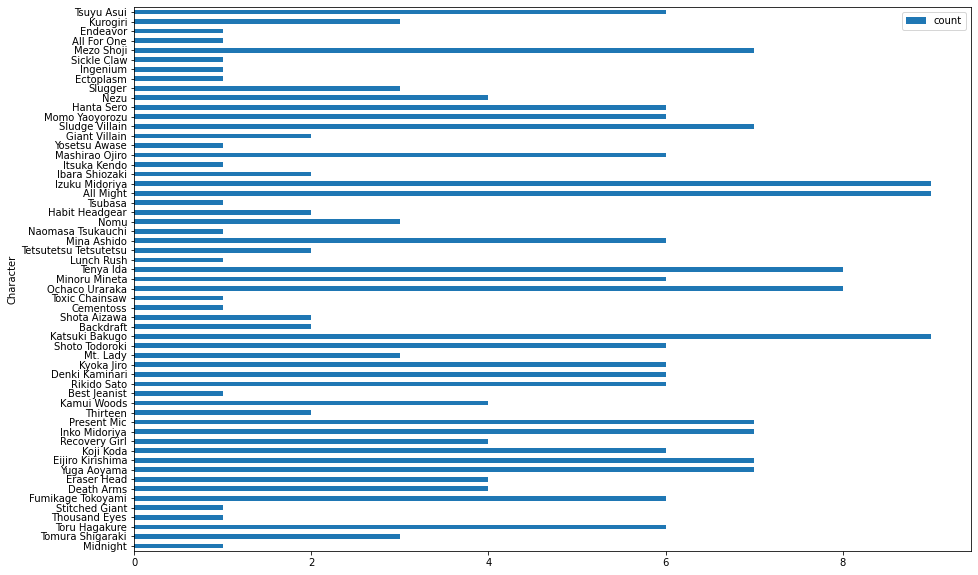

In [103]:
df_aggregated_pd = df_aggregated.toPandas()
df_aggregated_pd.plot(x='Character', kind='barh', figsize=(15,10))

In [105]:
df_aggregated_pd.head()

,Character,count
0,Midnight,1
1,Tomura Shigaraki,3
2,Toru Hagakure,6
3,Thousand Eyes,1
4,Stitched Giant,1


## 8. Save Data to File (currently errored)

In [109]:
df_aggregated.write.csv('aggregated')
df_aggregated.write.save('aggregated', format='json')
df_aggregated.write.save('aggregated', format='parquet')

Py4JJavaError: An error occurred while calling o515.csv.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:638)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:278)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:186)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:116)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:390)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:363)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:851)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Ljava/lang/String;I)Z
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1218)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1423)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$25(FileFormatWriter.scala:267)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:642)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:267)
	... 42 more
